# Import Libraries

In [1]:
import copy
import utils
import torch
import constants
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal, Categorical

from env import Env
from agent import Agent
from torchsummary import summary

# Initialise Environment

In [2]:
#initialise environment
min_x, max_x =  -0.110 - 0.175,   -0.110 + 0.175
min_y, max_y =   0.510 - 0.175,    0.510 + 0.175
min_z, max_z =               0,              0.4 

workspace_lim = np.asarray([[min_x, max_x], 
                            [min_y, max_y],
                            [min_z, max_z]])

print(f"workspace space: \n{workspace_lim}")

obj_dir = 'objects/blocks/'
N_obj   = 10

env = Env(obj_dir, N_obj, workspace_lim)

workspace space: 
[[-0.285  0.065]
 [ 0.335  0.685]
 [ 0.     0.4  ]]
[SUCCESS] restart environment
[SUCCESS] setup rgbd camera
[SUCCESS] load obj paths
[SUCCESS] randomly choose objects
[SUCCESS] randomly choose object colors
object 0: shape_0, pose: [-0.24822803135199445, 0.3719578451185758, 0.15, 6.090836346739635, 2.4899936348068263, 5.1345219872938666]
object 1: shape_1, pose: [0.04558707025022382, 0.5872244114392716, 0.15, 2.7644911054334047, 1.3173503291413569, 1.2894433011775677]
object 2: shape_2, pose: [-0.18157718713252155, 0.5972735671237414, 0.15, 0.9907520001958396, 1.1175286281142076, 2.0449444465153124]
object 3: shape_3, pose: [-0.21187198710255697, 0.5356147315337859, 0.15, 2.6491133541735037, 4.5544667802091165, 0.333371665051251]
object 4: shape_4, pose: [-0.09333488760050784, 0.45504861555994575, 0.15, 4.448664217774518, 4.201640634165735, 2.9672036896294025]
object 5: shape_5, pose: [-0.21781150742238958, 0.6661231860322663, 0.15, 0.8805160363494671, 1.95529833655

# Initialise Agent

In [3]:
agent = Agent(env, max_memory_size = 100)

device: cpu
[SUCCESS] initialise environment
[SUCCESS] initialise networks
[SUCCESS] initialise memory buffer


/home/ryan/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969824/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Gather Demonstration Experience

In [4]:
# agent.gather_guidance_experience(max_episode = 15)

# Get Train and Test Loader

In [5]:
agent.buffer_replay.load_buffer()

grasp_exp = agent.buffer_replay.get_experience_by_action_type(constants.GRASP)
push_exp  = agent.buffer_replay.get_experience_by_action_type(constants.PUSH)
hld_exp   = agent.buffer_replay.get_experience_by_home_type()

print(f"N_grasp_exp: {len(grasp_exp[0])}")
print(f"N_push_exp: {len(push_exp[0])}")
print(f"N_HLD_exp: {len(hld_exp[0])}")

hld_train_loader, hld_test_loader     = agent.get_train_test_dataloader_hld_net(hld_exp)
grasp_train_loader, grasp_test_loader = agent.get_train_test_dataloader(grasp_exp, is_grasp = True)
push_train_loader, push_test_loader   = agent.get_train_test_dataloader( push_exp, is_grasp = False)

N_grasp_exp: 75
N_push_exp: 25
N_HLD_exp: 14


# HLD-net clone

(14,) (14, 128, 128) (14,)
0.0


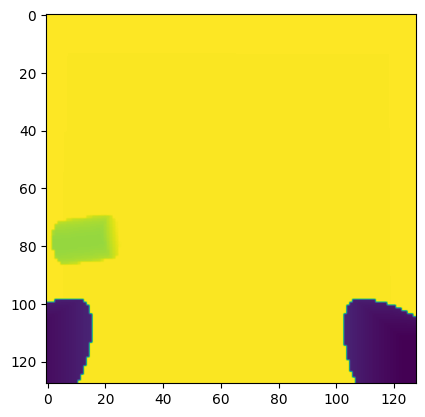

In [6]:
print(hld_exp[0].shape, hld_exp[1].shape, hld_exp[2].shape)
index = 11
print(hld_exp[2][index])
plt.imshow(hld_exp[1][index])

In [10]:
agent.behaviour_cloning_hld(hld_train_loader, agent.hld_net, num_epochs = 50)

Epoch 1/50, hld Loss: 0.028478
Epoch 2/50, hld Loss: 0.028478
Epoch 3/50, hld Loss: 0.028478
Epoch 4/50, hld Loss: 0.028478
Epoch 5/50, hld Loss: 0.028478
Epoch 6/50, hld Loss: 0.028478
Epoch 7/50, hld Loss: 0.028478
Epoch 8/50, hld Loss: 0.028478
Epoch 9/50, hld Loss: 0.028478
Epoch 10/50, hld Loss: 0.028478
Epoch 11/50, hld Loss: 0.028478
Epoch 12/50, hld Loss: 0.028478
Epoch 13/50, hld Loss: 0.028478
Epoch 14/50, hld Loss: 0.028478
Epoch 15/50, hld Loss: 0.028478
Epoch 16/50, hld Loss: 0.028478
Epoch 17/50, hld Loss: 0.028478
Epoch 18/50, hld Loss: 0.028478
Epoch 19/50, hld Loss: 0.028478
Epoch 20/50, hld Loss: 0.028478
Epoch 21/50, hld Loss: 0.028478
Epoch 22/50, hld Loss: 0.028478
Epoch 23/50, hld Loss: 0.028478
Epoch 24/50, hld Loss: 0.028478
Epoch 25/50, hld Loss: 0.028478
Epoch 26/50, hld Loss: 0.028478
Epoch 27/50, hld Loss: 0.028478
Epoch 28/50, hld Loss: 0.028478
Epoch 29/50, hld Loss: 0.028478
Epoch 30/50, hld Loss: 0.028478
Epoch 31/50, hld Loss: 0.028478
Epoch 32/50, hld 

In [ ]:
for state, target_action_type in hld_train_loader:

    target_action_type = target_action_type.to(agent.device)
    target_action_type = torch.nn.functional.one_hot(target_action_type.long(), 
                                                     num_classes = agent.N_gripper_action).float()


    action_type = agent.hld_net(state)

    print("===target===")
    print(target_action_type)
    print("===estimation===")
    print(action_type)

# Push Clone

In [ ]:
agent.behaviour_cloning(push_train_loader, agent.push_critic1, agent.push_critic2, agent.push_actor, num_epochs = 10, is_grasp = False)

# Grasp Clone

In [ ]:
agent.behaviour_cloning(grasp_train_loader, agent.grasp_critic1, agent.grasp_critic2, agent.grasp_actor, num_epochs = 10, is_grasp = True)